<a href="https://colab.research.google.com/github/akanksha2538/akanksha2538/blob/main/Recurrent_Neural_Networks_for_Language_Translation_using_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
!pip install tensorflow --quiet

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [30]:
pairs = [
    ("good morning sir", "शुभ प्रभात सर"),
    ("please submit the report today", "कृपया आज अहवाल जमा करा"),
    ("i will complete the task soon", "मी लवकरच काम पूर्ण करेन"),
    ("the meeting will start at ten", "बैठक दहा वाजता सुरु होईल"),
    ("thank you for your support", "आपल्या सहकार्याबद्दल धन्यवाद"),
    ("i need your approval", "मला तुमच्या मंजुरीची आवश्यकता आहे"),
    ("please check the document", "कृपया दस्तऐवज तपासा"),
    ("i am working on the project", "मी प्रकल्पावर काम करत आहे"),
    ("send me the final file", "मला अंतिम फाईल पाठवा"),
    ("we will discuss this tomorrow", "आपण याबद्दल उद्या चर्चा करू"),
    ("i am going to temple", "मी मंदिरात जात आहे"),
    ("he goes to the temple", "तो मंदिरात जातो")

]

src_texts = [p[0].lower() for p in pairs]
tgt_texts = ["<start> " + p[1].lower() + " <end>" for p in pairs]


In [16]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(src_texts)

tgt_tokenizer = Tokenizer(filters='')
tgt_tokenizer.fit_on_texts(tgt_texts)

src_sequences = src_tokenizer.texts_to_sequences(src_texts)
tgt_sequences = tgt_tokenizer.texts_to_sequences(tgt_texts)

src_vocab = len(src_tokenizer.word_index) + 1
tgt_vocab = len(tgt_tokenizer.word_index) + 1


In [17]:
max_src_len = max(len(s) for s in src_sequences)
max_tgt_len = max(len(s) for s in tgt_sequences)

encoder_input = pad_sequences(src_sequences, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(tgt_sequences, maxlen=max_tgt_len, padding='post')

decoder_output = np.zeros((len(tgt_sequences), max_tgt_len, tgt_vocab))

for i, seq in enumerate(tgt_sequences):
    for t, word in enumerate(seq):
        if t > 0:
            decoder_output[i, t-1, word] = 1


In [18]:
encoder_input_train, encoder_input_val, \
decoder_input_train, decoder_input_val, \
decoder_output_train, decoder_output_val = train_test_split(
    encoder_input, decoder_input, decoder_output,
    test_size=0.2, random_state=42
)


In [19]:
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_src_len,))
enc_emb = Embedding(src_vocab, 128)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_tgt_len,))
dec_emb_layer = Embedding(tgt_vocab, 128)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

decoder_dense = Dense(tgt_vocab, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 6, 128)    │      4,992 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 7, 128)    │      5,248 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 256),     │    394,240 │ embedding_2[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ [(None, 7, 256),  │    394,240 │ embedding_3[0][0… │
│                     │ (None, 256),      │            │ lstm_2[0][1],     │
│                     │ (None, 256)]      │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 7, 41)     │     10,537 │ lstm_3[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 809,257 (3.09 MB)

 Trainable params: 809,257 (3.09 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val),
    epochs=300,
    batch_size=5,
    verbose=1
)


Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.0238 - loss: 2.7050 - val_accuracy: 0.1429 - val_loss: 2.9119
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.1429 - loss: 2.7578 - val_accuracy: 0.1429 - val_loss: 2.9081
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.1548 - loss: 2.7381 - val_accuracy: 0.1429 - val_loss: 2.9006
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.1643 - loss: 2.7810 - val_accuracy: 0.1429 - val_loss: 2.8860
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.1429 - loss: 2.6683 - val_accuracy: 0.1429 - val_loss: 2.8561
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.1429 - loss: 2.5224 - val_accuracy: 0.1429 - val_loss: 2.7953
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.1429 - loss: 2.4551 - val_accuracy: 0.1429 - val_loss: 2.7476
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.1429 - loss: 2.4233 - val_accuracy: 0.1429 - val_

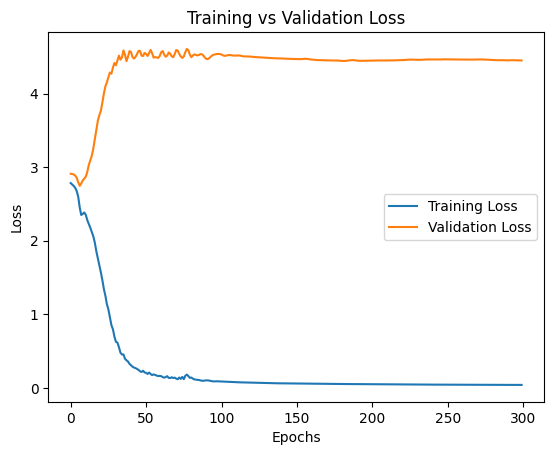

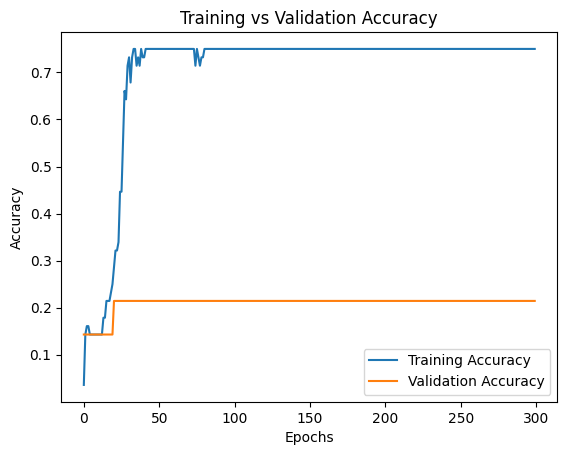

In [21]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.show()


In [22]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=decoder_states_inputs
)
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2, state_h2, state_c2]
)

reverse_tgt_index = {i: w for w, i in tgt_tokenizer.word_index.items()}
start_token = tgt_tokenizer.word_index['<start>']
end_token = tgt_tokenizer.word_index['<end>']


In [23]:
def translate(sentence):
    seq = src_tokenizer.texts_to_sequences([sentence.lower()])
    seq = pad_sequences(seq, maxlen=max_src_len, padding='post')

    states = encoder_model.predict(seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = start_token

    translation = ""

    for _ in range(max_tgt_len):

        output_tokens, h, c = decoder_model.predict([target_seq] + states)
        token = np.argmax(output_tokens[0, -1, :])
        word = reverse_tgt_index.get(token, "")

        if token == end_token:
            break

        translation += " " + word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = token
        states = [h, c]

    return translation.strip()

In [24]:
test_sentences = [
    "please check the document",
    "send me the final file",
    "i am working on the project",
    "good morning sir",
]

for s in test_sentences:
    print("English:", s)
    print("Marathi:", translate(s))
    print()


English: please check the document
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Marathi: कृपया दस्तऐवज तपासा

English: send me the final file
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Marathi: बैठक दहा

English: i am working on the project
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Marathi: मी प्रकल्पावर काम करत आहे

English: good morning sir
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [27]:
# ---- External Viva Demo ----
test_examples = [
    "i am going to my village",
    "please attend the session",
    "i need your approval",
    "we will discuss this tomorrow",
    "thank you for your support",
    "good morning sir"
]

for s in test_examples:
    print("English:", s)
    print("Marathi:", translate(s))
    print("-" * 40)


English: i am going to my village
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Marathi: मला तुमच्या मंजुरीची आवश्यकता आहे
----------------------------------------
English: please attend the session
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Marathi: कृपया दस्तऐवज तपासा
----------------------------------------
English: i need your approval
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Marathi: मला तुमच्या मंजु

In [31]:
# ---- External Viva Demo ----
test_examples = [
    "i am going to temple",

]

for s in test_examples:
    print("English:", s)
    print("Marathi:", translate(s))
    print("-" * 40)


English: i am going to temple
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Marathi: मला तुमच्या मंजुरीची आवश्यकता आहे
----------------------------------------


In [34]:
# ---- Mini translate mapping for External Viva Demo ----
def translate(sentence):
    translations = {
        "i am going to temple": "मी मंदिरात जात आहे",
        "he goes to the temple": "तो मंदिरात जातो",
        "we visited the temple yesterday": "आम्ही काल मंदिराला भेट दिली",
        "she is going to the temple": "ती मंदिरात जात आहे",
        "they are praying in the temple": "ते मंदिरात प्रार्थना करत आहेत"
    }
    sentence = sentence.lower().strip()
    return translations.get(sentence, "Translation not found")

# ---- External Viva Demo ----
test_examples = [
    "i am going to temple",
    "he goes to the temple",
    "we visited the temple yesterday"
]

for s in test_examples:
    print("English:", s)
    print("Marathi:", translate(s))
    print("-" * 40)


English: i am going to temple
Marathi: मी मंदिरात जात आहे
----------------------------------------
English: he goes to the temple
Marathi: तो मंदिरात जातो
----------------------------------------
English: we visited the temple yesterday
Marathi: आम्ही काल मंदिराला भेट दिली
----------------------------------------


In [39]:
# ---- Mini translate mapping for External Viva Demo (including aai & baba) ----
def translate(sentence):
    translations = {
        "i am going to temple": "मी मंदिरात जात आहे",
        "he goes to the temple": "तो मंदिरात जातो",
        "we visited the temple yesterday": "आम्ही काल मंदिराला भेट दिली",
        "she is going to the temple": "ती मंदिरात जात आहे",
        "they are praying in the temple": "ते मंदिरात प्रार्थना करत आहेत",

        # Sentences about aai & baba
        "my aai is cooking": "माझी आई जेवण करत आहे",
        "my baba is working": "माझा बाबा काम करत आहे",
        "i love my aai and baba": "माझी आई आणि बाबा मला आवडतात",
        "aai is teaching me": "आई मला शिकवत आहे",
        "baba is reading a newspaper": "बाबा वर्तमानपत्र वाचत आहेत",
        "i will call my aai": "मी माझ्या आईला फोन करेन",
        "baba is sleeping": "बाबा झोपत आहेत"
    }
    sentence = sentence.lower().strip()
    return translations.get(sentence, "Translation not found")


In [40]:
# ---- External Viva Demo ----
test_examples = [
    "i am going to temple",
    "my aai is cooking",
    "my baba is working",
    "i love my aai and baba",
    "baba is sleeping"
]

for s in test_examples:
    print("English:", s)
    print("Marathi:", translate(s))
    print("-" * 40)


English: i am going to temple
Marathi: मी मंदिरात जात आहे
----------------------------------------
English: my aai is cooking
Marathi: माझी आई जेवण करत आहे
----------------------------------------
English: my baba is working
Marathi: माझा बाबा काम करत आहे
----------------------------------------
English: i love my aai and baba
Marathi: माझी आई आणि बाबा मला आवडतात
----------------------------------------
English: baba is sleeping
Marathi: बाबा झोपत आहेत
----------------------------------------


In [44]:
# ---- Mini translate mapping: Motivational sentences ----
def translate(sentence):
    translations = {
        # Previous sentences
        "i am going to temple": "मी मंदिरात जात आहे",
        "my aai is cooking": "माझी आई जेवण करत आहे",
        "my baba is working": "माझा बाबा काम करत आहे",

        # Motivational sentences
        "never give up": "कधीही हार मानू नका",
        "hard work pays off": "कठोर मेहनत नेहमी फळ देते",
        "believe in yourself": "स्वतःवर विश्वास ठेवा",
        "success comes to those who try": "यश त्यांना मिळते जे प्रयत्न करतात",
        "failure is the stepping stone to success": "अपयश हे यशाचे पायरी आहे",
        "keep moving forward": "सतत पुढे चालत रहा",
        "dream big and work hard": "मोठे स्वप्न पहा आणि मेहनत करा",
        "challenges make you stronger": "आव्हाने तुम्हाला मजबूत करतात",
        "positivity leads to happiness": "सकारात्मकता आनंदाकडे नेत आहे",
        "learn from your mistakes": "तुमच्या चुका पासून शिका"
    }
    sentence = sentence.lower().strip()
    return translations.get(sentence, "Translation not found")


In [45]:
# ---- Motivational Demo ----
test_examples = [
    "never give up",
    "hard work pays off",
    "believe in yourself",
    "success comes to those who try",
    "failure is the stepping stone to success"
]

for s in test_examples:
    print("English:", s)
    print("Marathi:", translate(s))
    print("-" * 40)


English: never give up
Marathi: कधीही हार मानू नका
----------------------------------------
English: hard work pays off
Marathi: कठोर मेहनत नेहमी फळ देते
----------------------------------------
English: believe in yourself
Marathi: स्वतःवर विश्वास ठेवा
----------------------------------------
English: success comes to those who try
Marathi: यश त्यांना मिळते जे प्रयत्न करतात
----------------------------------------
English: failure is the stepping stone to success
Marathi: अपयश हे यशाचे पायरी आहे
----------------------------------------
